In [12]:
import fastf1 as ff1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
ff1.Cache.enable_cache('../cache')
pd.options.mode.chained_assignment = None

In [13]:
team = 'Alpine'
driver_1 = 'OCO'
driver_2 = 'GAS'
comparison_drivers = ['ALB', 'TSU', 'RIC', 'HUL', 'MAG', 'ZHO', 'BOT']

plt.style.use('dark_background')

In [14]:
event = ff1.get_event(2024, 6)

In [15]:
import os

# Set your desired directory path here
directory_path = "./" + str(event.year) + "/" + event.Location + "/race"

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' was created.")
else:
    print(f"Directory '{directory_path}' already exists.")

Directory './2024/Miami/race' already exists.


In [16]:
r = event.get_race()
r.load()

core           INFO 	Loading data for Miami Grand Prix - Race [v3.3.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']


In [17]:
r.laps['LapTime'] = r.laps['LapTime'].dt.total_seconds()
r.laps['Sector1Time'] = r.laps['Sector1Time'].dt.total_seconds()
r.laps['Sector2Time'] = r.laps['Sector2Time'].dt.total_seconds()
r.laps['Sector3Time'] = r.laps['Sector3Time'].dt.total_seconds()
comparison_laps = r.laps.pick_drivers(comparison_drivers)
alpine_laps = r.laps.pick_team(team)

In [18]:
from fastf1 import utils, plotting
import matplotlib.pyplot as plt

def plot_pace(laps, ax, label, wo_box = True):
    added_labels = set()
    if wo_box:
        d_laps = laps.pick_wo_box().pick_quicklaps()
    else:
        d_laps = laps
    for (no, stint_laps) in d_laps.groupby('Stint'):
        # Check if the driver's label has already been added
        if label not in added_labels:
            ax.plot(stint_laps['LapNumber'], stint_laps['LapTime'], color=plotting.driver_color(label), label=label)
            # Add the driver's name to the set to avoid adding it again
            added_labels.add(label)
        else:
            # Add to the plot without a label to avoid duplication in the legend
            ax.plot(stint_laps['LapNumber'], stint_laps['LapTime'], color=plotting.driver_color(label))
    return ax

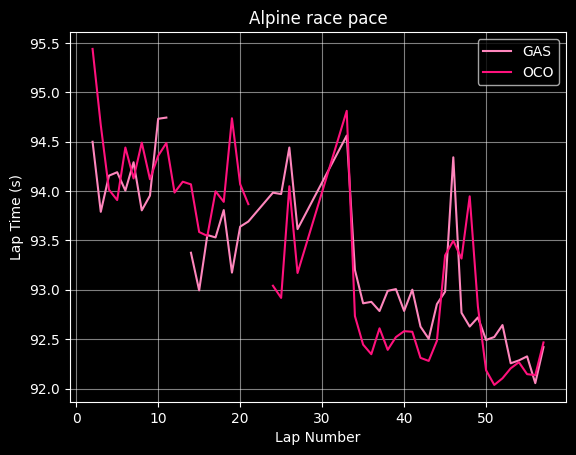

In [19]:
fig = plt.figure()
ax = plt.subplot()

for driver in alpine_laps['Driver'].unique():
    d_laps = alpine_laps.pick_driver(driver)
    ax = plot_pace(d_laps, ax, driver)

plt.legend(loc='upper right')
ax.grid(alpha=0.5)
ax.set_xlabel('Lap Number')
ax.set_ylabel('Lap Time (s)')
plt.title('Alpine race pace')
plt.savefig(directory_path + '/team_pace', bbox_inches = "tight")
plt.show()


IndexError: list index out of range

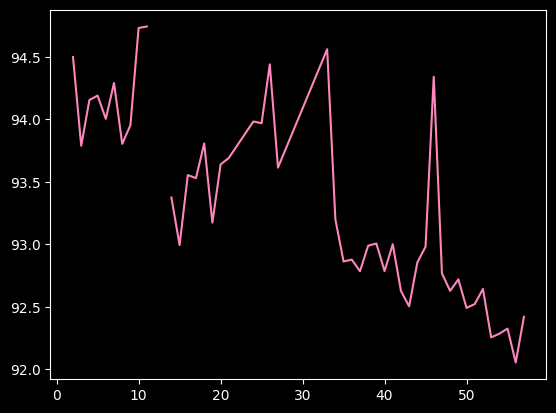

In [43]:
import matplotlib.pyplot as plt
import numpy as np  # Importing numpy for mean calculation

fig = plt.figure()
ax = plt.subplot()

y_pos = 93
x_pos = []
for driver in alpine_laps['Driver'].unique():
    d_laps = alpine_laps.pick_driver(driver).pick_laps(range(20, 100))
    
    # Assuming plot_pace() is a function you've defined to plot each driver's pace
    ax = plot_pace(d_laps, ax, driver)
    y_pos += 0.3
    d_laps['Stint'] = d_laps['Stint'] - 1
    # Group laps by stint
    for stint, stint_laps in d_laps.pick_quicklaps().pick_wo_box().groupby('Stint'):
        # Calculate the average lap time for the stint
        avg_lap_time = np.median(stint_laps['LapTime'])
        
        # Choose a position for the text. For simplicity, we'll place it at the average lap number
        # of the stint and use the average lap time for the y-coordinate. Adjust as necessary.
        lap_number_position = np.mean(stint_laps['LapNumber'])
        if len(x_pos) < stint:
            x_pos.append(lap_number_position)

        # Adding text to the plot. Adjust the vertical position slightly to avoid overlap.
        ax.text(x_pos[int(stint - 1)], y_pos, f'{avg_lap_time:.2f}s',
                verticalalignment='bottom', horizontalalignment='center', fontsize=8, color=plotting.driver_color(driver),
                bbox=dict(facecolor='white', edgecolor='none', alpha=1, boxstyle='round,pad=0.2'))

plt.legend(loc='upper right')
ax.grid(alpha=0.5)
ax.set_xlabel('Lap Number')
ax.set_ylabel('Lap Time (s)')
plt.title('Alpine race pace')
plt.savefig(directory_path + '/team_pace_label', bbox_inches = "tight")
plt.show()


Comparing both Alpine driver's pace, we can compare their stints on the hards as after's Ocon extra stop, they had a near identical strategy. There is a lot of impurity as the front runners started lapping them in the middle of the race but their pace was very close. With Gasy struggling on his warmup of his first set of hard and having generally less degradation. On the last stint Gasly had much better pace, but as Ocon was dead last and realistically out of the fight he might have slowed down on purpose.

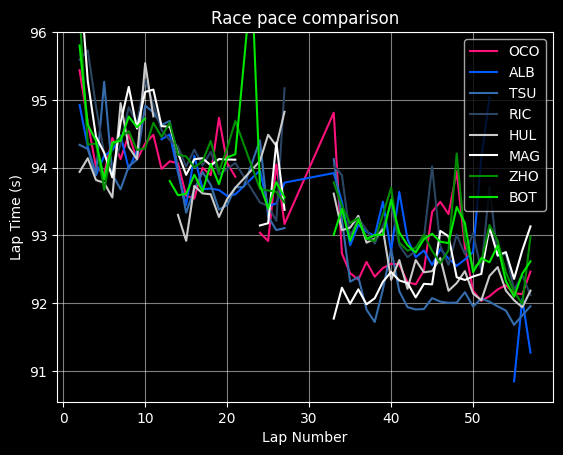

In [42]:
fig = plt.figure()
ax = plt.subplot()

min_lap = '0'
max_lap = '100'

d_laps = alpine_laps.pick_driver('OCO').query('LapNumber < ' + max_lap + ' & LapNumber > ' + min_lap)
ax = plot_pace(d_laps, ax, 'OCO')

for driver in comparison_drivers:
    d_laps = comparison_laps.pick_driver(driver).query('LapNumber < ' + max_lap + ' & LapNumber > ' + min_lap)
    ax = plot_pace(d_laps, ax, driver)

plt.legend(loc='upper right')
ax.grid(alpha=0.5)
ax.set_xlabel('Lap Number')
ax.set_ylabel('Lap Time (s)')
ax.set_ylim(top=96)
plt.title('Race pace comparison')
plt.savefig(directory_path + '/pace_comparison', bbox_inches = "tight")
plt.show()


I'm once again comparing only the laps on the hards to better estimate the pace order of the cars. It's a bit hard to see as we're comparing a lot of drivers but in race trim Gasly's Alpine was one of the quickest. Surprisingly faster Tsunoda and the Haas of Kevin Magnussen.

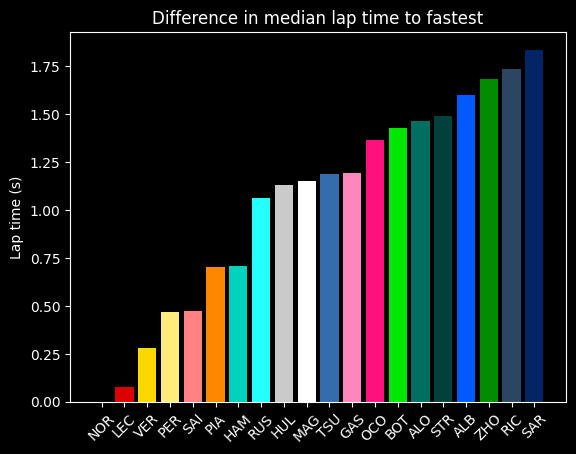

In [22]:
meds = r.laps.pick_quicklaps().groupby('Driver')['LapTime'].median()
meds = meds - min(meds)
meds = meds.sort_values()
fig, ax = plt.subplots()
ax.bar(meds.index, meds, color=[plotting.driver_color(d) for d in meds.index])
ax.set_title('Difference in median lap time to fastest')
ax.set_ylabel('Lap time (s)')
plt.xticks(rotation=45)
plt.show()

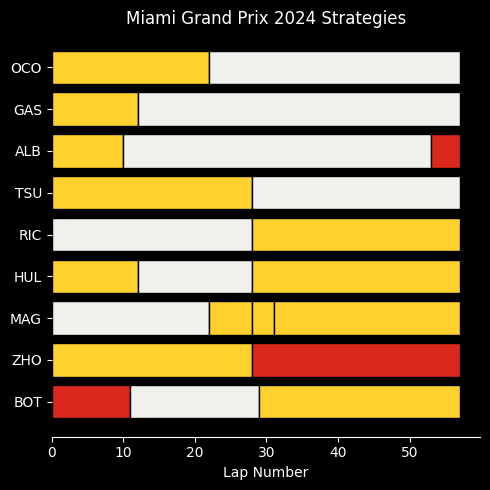

<Axes: title={'center': 'Miami Grand Prix 2024 Strategies'}, xlabel='Lap Number'>

In [23]:
def plot_strategies(drivers, ax = None, save = True):
    stints = r.laps[["Driver", "Stint", "Compound", "LapNumber"]]
    stints = stints.groupby(["Driver", "Stint", "Compound"])
    stints = stints.count().reset_index()
    stints = stints.rename(columns={"LapNumber": "StintLength"})
    ax_was_none = ax == None
    if ax == None:
        fig, ax = plt.subplots(figsize=(5, 5))

    for driver in drivers:
        driver_stints = stints.loc[stints["Driver"] == driver]

        previous_stint_end = 0
        for idx, row in driver_stints.iterrows():
            # each row contains the compound name and stint length
            # we can use these information to draw horizontal bars
            plt.barh(
                y=driver,
                width=row["StintLength"],
                left=previous_stint_end,
                color=plotting.COMPOUND_COLORS[row["Compound"]],
                edgecolor="black",
                fill=True
            )

            previous_stint_end += row["StintLength"]
    if ax_was_none:
        plt.title(event.EventName + " " + str(event.year) + " Strategies")
        plt.xlabel("Lap Number")
    plt.grid(False)
    ax.invert_yaxis()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    if save:
        plt.savefig(directory_path + '/strategies', bbox_inches = "tight")
        plt.show()
    return ax
plot_strategies([
        driver_1,
        driver_2
    ] + comparison_drivers)

In [24]:
def get_gaps(lap_number: int):
    lap_x = r.laps.pick_lap(lap_number)[['Driver', 'Position', 'Time']]
    lap_x.sort_values('Time', inplace=True)
    lap_x['GapToAhead'] = lap_x['Time'].dt.total_seconds() - lap_x['Time'].dt.total_seconds().shift().fillna(lap_x['Time'].dt.total_seconds())
    lap_x['GapToLeader'] = lap_x['GapToAhead'].cumsum()
    return lap_x[['Driver', 'Position', 'GapToAhead', 'GapToLeader']].set_index('Driver')
# Situation at lap 5
lap_5 = get_gaps(5)

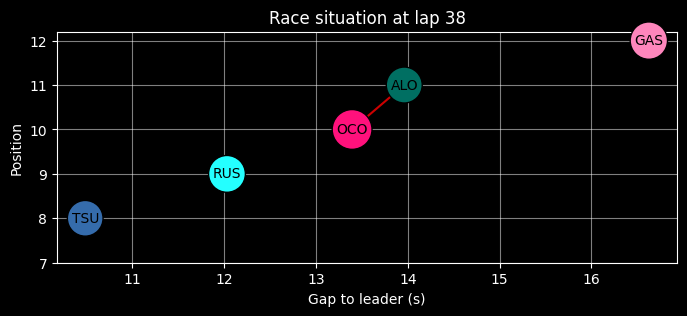

In [25]:
def plot_race_situation(lap_number: int, min_pos = 0, max_pos = 21, max_gap = np.Inf):
    fig, ax = plt.subplots(figsize=(8,3))

    lap_data = get_gaps(lap_number)
    lap_data = lap_data[(lap_data['Position'] > min_pos) & (lap_data['Position'] < max_pos)]
    if (len(lap_data[lap_data['GapToAhead'] > max_gap]) > 0): # Remove big gaps
        late_driver = lap_data[lap_data['GapToAhead'] > max_gap].iloc[0].name
        lap_data = lap_data.loc[:late_driver].iloc[:-1] # Remove driver and all after

    ax.plot(
    lap_data['GapToLeader'],
    lap_data['Position'],
    'o',
    )
    ax.grid(alpha=0.5)

    for i, (driver, (position, gap_ahead, gap_leader)) in enumerate(lap_data.iterrows()):
        if position <= min_pos:
            break
        color = plotting.driver_color(driver)
        ax.text(
            gap_leader,
            position,
            driver,
            ha='center',
            va='center',
            color='black',
            bbox=dict(facecolor=color, edgecolor='black', boxstyle='circle')
        )
        if gap_ahead < 1 and i > 0:
            driver_ahead = lap_data.iloc[i - 1]
            ax.plot(
                [gap_leader, driver_ahead['GapToLeader']],
                [position, driver_ahead['Position']],
                color='red',
                alpha=0.8
            )

    ax.set_ylim(bottom=min_pos)
    plt.xlabel('Gap to leader (s)')
    plt.ylabel('Position')
    plt.title('Race situation at lap ' + str(lap_number))
    plt.savefig(directory_path + '/lap_' + str(lap_number), bbox_inches = "tight")

plot_race_situation(38, 7, 13, 100)

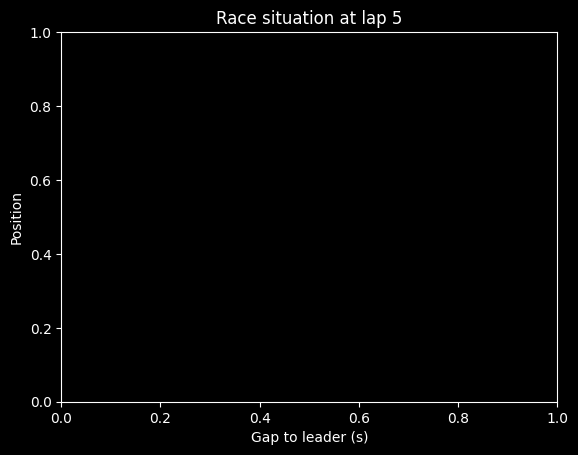

In [26]:

min_pos = 9

lap_5 = lap_5[(lap_5['Position'] > min_pos) & (lap_5['GapToAhead'] < 10)]

ax.plot(
   lap_5['GapToLeader'],
   lap_5['Position'],
   'o',
)
ax.grid(alpha=0.5)

for i, (driver, (position, gap_ahead, gap_leader)) in enumerate(lap_5.iterrows()):
    if position <= min_pos:
        continue
    color = plotting.driver_color(driver)
    ax.text(
         gap_leader,
         position,
         driver,
         ha='center',
         va='center',
         color='black',
         bbox=dict(facecolor=color, edgecolor='black', boxstyle='circle')
    )
    if gap_ahead < 1 and i > 0:
        driver_ahead = lap_5.iloc[i - 1]
        ax.plot(
            [gap_leader, driver_ahead['GapToLeader']],
            [position, driver_ahead['Position']],
            color='red',
            alpha=0.8
        )

ax.set_ylim(bottom=min_pos)
plt.xlabel('Gap to leader (s)')
plt.ylabel('Position')
plt.title('Race situation at lap 5')
plt.savefig(directory_path + '/lap_5', bbox_inches = "tight")

In [27]:
pit_seq_data = r.laps.pick_drivers(['OCO', 'MAG', 'ALB']).pick_laps(range(5, 12))[['Driver', 'LapNumber', 'LapTime', 'PitInTime', 'PitOutTime']].groupby('Driver').sum()
pit_seq_data['PitTime'] = pit_seq_data['PitOutTime'] - pit_seq_data['PitInTime']

pit_time_on_track = r.laps.pick_drivers(['OCO', 'MAG', 'ALB']).pick_laps(range(5, 12)).pick_wo_box()[['Driver', 'LapTime']].groupby('Driver').sum()

pit_time_on_track['LapTime'] = pit_time_on_track['LapTime'] - min(pit_time_on_track['LapTime']) 
pit_seq_data['PitTime'] = pit_seq_data['PitTime'] - min(pit_seq_data['PitTime'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


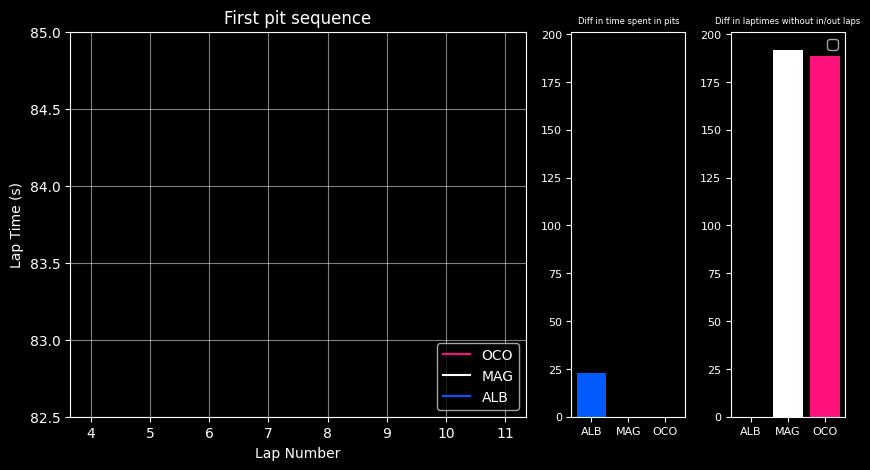

In [28]:
def plot_lap_comparison(laps, ax, drivers, min_lap, max_lap):
    for driver in drivers:
        d_laps = laps.pick_driver(driver).query('LapNumber < ' + max_lap + ' & LapNumber > ' + min_lap)
        ax = plot_pace(d_laps, ax, driver, False)

    plt.legend(loc='upper right')
    ax.grid(alpha=0.5)
    ax.set_xlabel('Lap Number')
    ax.set_ylabel('Lap Time (s)')
    return ax

fig, (ax, ax2, ax3) = plt.subplots(figsize=(10, 5), ncols=3, width_ratios=[0.8, 0.2, 0.2])
ax = plot_lap_comparison(
    r.laps,
    ax,
    ['OCO', 'MAG', 'ALB'],
    '3',
    '12'
)
ax.set_title('First pit sequence')
ax.set_ylim(bottom=82.5, top=85)
ax.legend(loc='lower right')

ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.bar(pit_seq_data.index, pit_seq_data['PitTime'].dt.total_seconds(), color=[plotting.driver_color(d) for d in pit_seq_data.index], zorder=1)
#ax2.set_ylim(17, 19)
ax2.set_title('Diff in time spent in pits', fontsize=6)

ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.bar(pit_time_on_track.index, pit_time_on_track['LapTime'], color=[plotting.driver_color(d) for d in pit_time_on_track.index], zorder=1)
ax3.set_title('Diff in laptimes without in/out laps', fontsize=6)
ax2.sharey(ax3)
#ax3.set_ylim(417, 419)
#ax2.grid(which='major', axis='y', zorder=-1, alpha=0.5)
plt.savefig(directory_path + '/pit_seq_1', bbox_inches = "tight")
plt.show()


In [29]:
def plot_time_gap(driver_1, driver_2, min_lap, max_lap, save = True, ax = None):
    gap_alb_gas = r.laps.pick_drivers([driver_1, driver_2]).groupby('LapNumber')['LapStartTime'].diff().dropna().dt.total_seconds().reset_index().shift(1).iloc[min_lap:max_lap]['LapStartTime']

    import matplotlib.ticker as plticker
    ax_was_none = ax == None
    if ax == None:
        fig, ax = plt.subplots()
    ax.hlines([0], -1, len(gap_alb_gas) + 1, alpha = 0.5, linestyles='dotted')
    loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.yaxis.set_minor_locator(loc)
    ax.grid(alpha=0.5)
    ax.grid(alpha=0.2, which='minor')
    ax.plot(gap_alb_gas, '.-')
    ax.set_xticks(np.arange(0, len(gap_alb_gas) + 1, 5))
    #ax.set_yticks(np.sort((list(np.arange(round(min(gap_alb_gas)), max(gap_alb_gas), 5)) + [0])))
    if ax_was_none:
        ax.set_xlabel('Lap Number')
    ax.set_ylabel('Gap (s)')
    ax.set_xlim(0, len(gap_alb_gas))
    ax.set_title('Gap between ' + plotting.DRIVER_TRANSLATE[driver_1] + ' and ' + plotting.DRIVER_TRANSLATE[driver_2])
    if save:
        plt.savefig(directory_path + '/gap_' + driver_1 + '_' + driver_2 + '_' + str(min_lap) + '_' + str(max_lap), bbox_inches = "tight")
    return ax


<Axes: title={'center': 'Gap between esteban ocon and kevin magnussen'}, xlabel='Lap Number', ylabel='Gap (s)'>

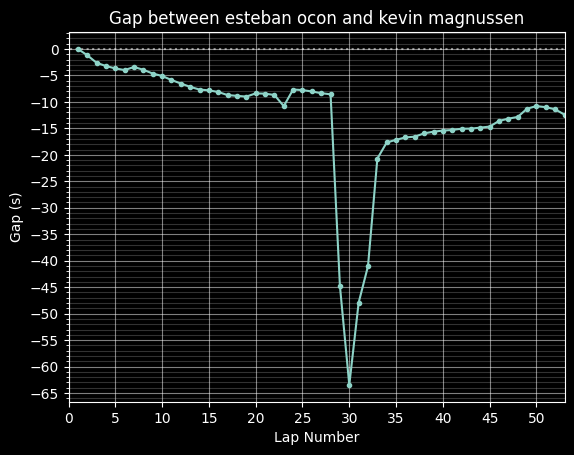

In [30]:
plot_time_gap('OCO', 'MAG', 1, 54)

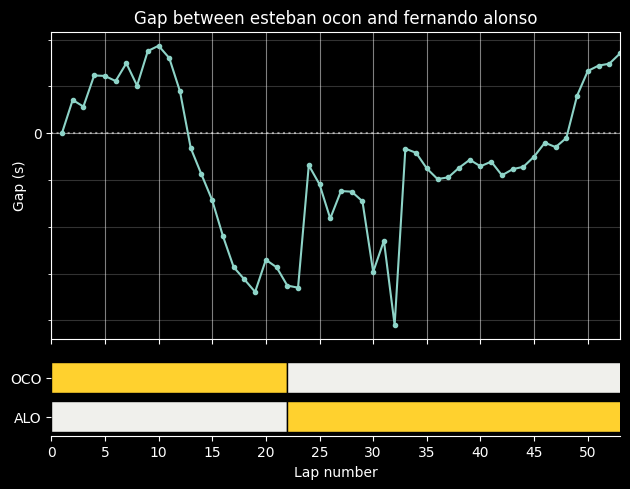

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[0.8, 0.2])
ax1 = plot_time_gap('OCO', 'ALO', 1, 54, ax=ax1, save=False)
ax2 = plot_strategies(['OCO', 'ALO'], ax=ax2, save=False)
ax2.set_xlabel('Lap number')
plt.savefig(directory_path + '/gap_oco_alo_strat', bbox_inches = "tight")

In [32]:
gap_alb_gas = r.laps.pick_drivers(['HUL', 'GAS']).groupby('LapNumber')['LapStartTime'].diff().dropna().dt.total_seconds().reset_index().shift(1).iloc[1:-1]['LapStartTime']

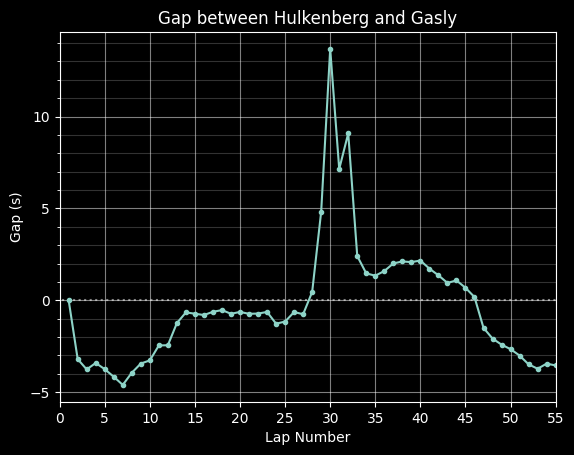

In [33]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots()
ax.hlines([0], -1, len(gap_alb_gas) + 1, alpha = 0.5, linestyles='dotted')
loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_minor_locator(loc)
ax.grid(alpha=0.5)
ax.grid(alpha=0.2, which='minor')
ax.plot(gap_alb_gas, '.-')
ax.set_xticks(np.arange(0, len(gap_alb_gas) + 1, 5))
#ax.set_yticks(np.sort((list(np.arange(round(min(gap_alb_gas)), max(gap_alb_gas), 5)) + [0])))

ax.set_xlabel('Lap Number')
ax.set_ylabel('Gap (s)')
ax.set_xlim(0, len(gap_alb_gas))
ax.set_title('Gap between Hulkenberg and Gasly')
plt.savefig(directory_path + '/gap_hul_gas_full', bbox_inches = "tight")


In [34]:
print(
    3 + 17,
    9 + 11,
    7 + 14,
    4 + 18
)

20 20 21 22


Next up, I'm trying to gather if the strategy the team opted with Gasly was better or worse than Ocon's and how much. By pitting on lap 18 like Hulkenberg, Gasly did the longest stint on the mediums of all the midfield. Surprisingly he managed to keep up with Hulkenberg on the hards. This strategy was in some way a hopping for a safety car between lap 10 and 20, which did happen on lap 17 as they pitted under the virtual safety car caused by Hamilton retiring.

We can also notice the longer pit stop of Gasly about 1.5 seconds slower than his direct competitor and might show how good Williams's stop was for Albon. Interestingly Gasly really struggled to get his hards up to speed as he lost nearly 3 seconds compared to the Albon in the laps following his pitstop.

To compare the strategies the best comparison would be Hulkenberg and Magnussen as Ocon did an unplanned pitstop on lap 17 to remove a tear off we cannot use his data. Looking at this graph, Magnussen had about a 2 second lead when he pitted on lap 8. He came out about 18 seconds behind Hulkenberg and gained time with his fresher rubber. Hulkenberg pitted under vsc on lap 18 which meant his pitstop costed only 12 seconds roughly. Which made it equivalent in term of track position to Magnussen's strategy, although Hulk had now fresher tire to play with. Essentialy, Hulkenberg and Gasly beneffited from 8 laps fresher tire thanks to this strategy.

Unfortunatly, Ocon had to pit and extra time ruining his race because of tear off.

In [35]:
pit_data = r.laps.pick_drivers(['GAS', 'HUL', 'ALB', 'OCO']).pick_laps(range(5, 20))[['Driver', 'PitInTime', 'PitOutTime']].groupby('Driver').sum()
pit_data['PitTime'] = pit_data['PitOutTime'] - pit_data['PitInTime']
pit_data['PitTime'] = pit_data['PitTime'] - min(pit_data['PitTime'])
pit_data = pit_data['PitTime']
pit_data['OCO'] = pit_seq_data.loc['OCO']['PitTime'] # Replace Ocon's pit with first one
pit_data

Driver
ALB   0 days 00:00:22.680000
GAS   0 days 00:00:22.522000
HUL   0 days 00:00:23.080000
OCO          0 days 00:00:00
Name: PitTime, dtype: timedelta64[ns]

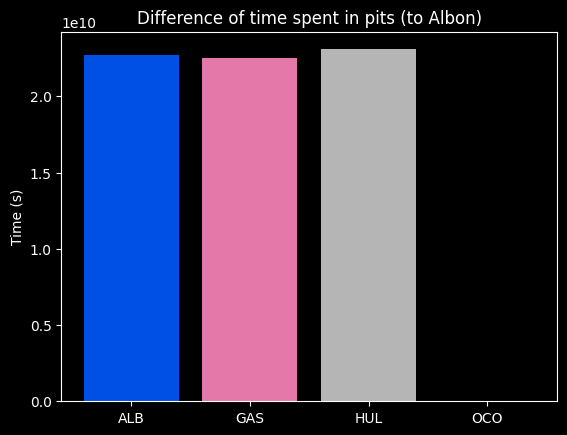

In [36]:
fig, ax = plt.subplots()
ax.bar(pit_data.index, pit_data, color=[plotting.driver_color(d) for d in pit_data.index], alpha=0.9)
ax.set_title('Difference of time spent in pits (to Albon)')
ax.set_ylabel('Time (s)')
plt.savefig(directory_path + '/pit_times', bbox_inches = "tight")


(89.6388, 90.0)

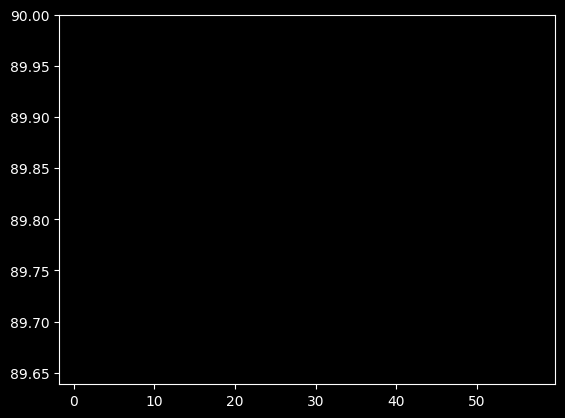

In [37]:
ax = plt.subplot()
ax.plot(r.laps.pick_driver('GAS')[['LapTime', 'LapNumber']].set_index('LapNumber'))

ax.plot(r.laps.pick_driver('HUL')[['LapTime', 'LapNumber']].set_index('LapNumber'))
ax.set_ylim(top=90)

In [38]:
pit_seq_data['PitTime'].dt.total_seconds()

Driver
ALB    22.68
MAG     0.00
OCO     0.00
Name: PitTime, dtype: float64

In [39]:
alpine_laps.query('Stint == 2')[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time']].groupby('Driver').median().diff()

,Sector1Time,Sector2Time,Sector3Time
Driver,,,
GAS,NaN,NaN,NaN
OCO,-0.332,-0.104,-0.036


In [40]:
alpine_laps.query('Stint == 1')[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time']].groupby('Driver').median().diff()

,Sector1Time,Sector2Time,Sector3Time
Driver,,,
GAS,NaN,NaN,NaN
OCO,0.017,-0.0675,0.068


In [41]:
alpine_laps.query('Stint == 3 and LapNumber < 43')[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time']].groupby('Driver').median().diff()

,Sector1Time,Sector2Time,Sector3Time
Driver,,,
